How to run a simple N-body code
====================

Here we will generate initial conditions for an N-body code, run a small simulation and analyse the results. This analysis is performed on a 100 star cluster in a 1 pc virial-radius King model. Stellar masses are taken randomly from a Salpeter distribution.
Stellar evolution is ignored in this simulation.

For reference you can read chapter 2 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate initial conditions (mass function, King-model)
- to initialize a gravitational N-body code
- channels and intra-code data transfer
- detecting binaries
- plotting results
- making cumulative distributions

In [1]:
%matplotlib inline
import numpy
import pandas as pd
from matplotlib import pyplot
from amuse.units import units

We start by setting-up a simulation by specifying a stellar mass distribution

In [2]:
n_stars = 100
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_stars = new_powerlaw_mass_distribution(n_stars, 0.1|units.MSun, 
                                        100|units.MSun, alpha_IMF)
#Salpeter mass distribution of 100 stars in the range of 0.1 to 100x the mass of the sun.

Now check to see if this indeed gives one the expected mass function by plotting the cumulative distribution against a theoretical distribution.

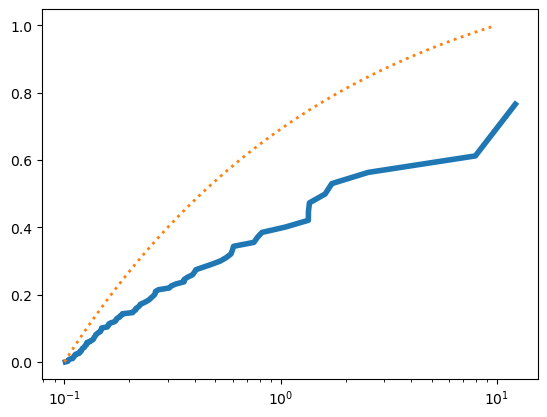

In [4]:
def plot_cdf(m, alpha_IMF=-2.35):
    m = sorted(m.value_in(units.MSun)) #Sort the 100 stars in order of mass
    fm = numpy.array([0]) #creating an empty numpy array
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi) #For each star in m, append the star mass + the mass of the previous fm index
    fm /= max(fm) #Divide fm by the mass of the largest star
    from amuse.plot import plot
    pyplot.plot(m, fm[:len(m)], lw=4, ls="-") #Plot m against fm with a solid line
    x = 10**numpy.arange(-1.0, 1.0, 1/len(m)) # 10** 2m evenly spaced values between -1 and 1 in steps of 1/(the length of m)
    y = x**(alpha_IMF+2) #Why +2 here?
    fy = numpy.array([0])
    for yi in y:
        fy = numpy.append(fy, fy[-1] + yi) #Same as above; append the 2m values in y
    fy /= max(fy) #"Normalize" by dividing by the largest mass
    pyplot.plot(x, fy[:len(x)], lw=2, ls=":") #Dotted line
    pyplot.semilogx() #log scale on the x axis
    pyplot.show()
plot_cdf(m_stars)

### Question:
Can you explain why the dotted curve does not overplot with the solid curve?

Now we can initialize the cluster size and declare the converter.

### Converter
N-body codes operate using special dimensionless N-body units (where the gravitational constant is set to unity). In order to make the code understand SI units, we must pass it a unit converter. This contains two quantities in the relevant unit system, from which AMUSE derives the proper unit conversion. Best practice is to keep those quantities on the order of the system's scale (e.g. the total mass and the radius of the outermost planet in a planetary system) to ensure numerical stability.

Also see the documentation on the importance of [converters](https://amuse.readthedocs.io/en/latest/reference/quantities_and_units.html?highlight=generic%20units#module-amuse.units.generic_unit_system) in AMUSE. 


In [5]:
#Q: The dotted curve does not overplot with the solid curve because they are generated in different ways. The dotted line
#is generated in equal steps; there is no guarantee that the salpeter function will be as well. In fact, it would be
#very strange if it did.

In [6]:
r_cluster = 1.0 | units.parsec #We have defined the planetary system to be 1 parsec in radius
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_stars.sum(),r_cluster)
from amuse.ic.kingmodel import new_king_model
W0 = 4.5 #"King dimensionless depth"
bodies=new_king_model(n_stars, W0, convert_nbody=converter)
bodies.scale_to_standard(converter)

Check the result by plotting the X-Y positions of the bodies.

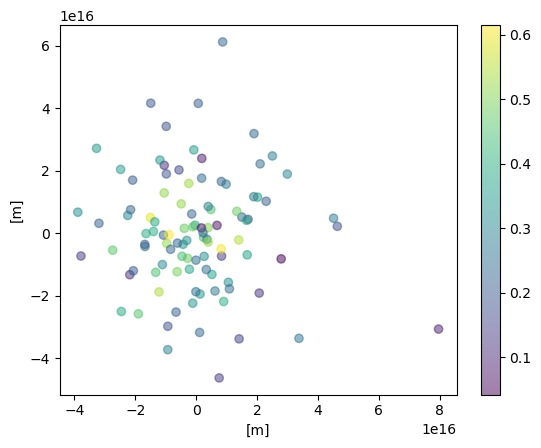

In [7]:
from amuse.plot import scatter
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    scatter(bodies.x, bodies.y, c=v.value_in(units.kms), alpha=0.5) #color describes the v value since this is a 2D plot
    pyplot.colorbar()
    pyplot.show()
plot_snapshot(bodies)

cluster at Time= 0.0 Myr Mass= 51.9406017253 MSun Rvir= 1.0 parsec
cluster at Time= 10.0 Myr Mass= 51.9406017253 MSun Rvir= 0.961085989078 parsec
cluster at Time= 20.0 Myr Mass= 51.9406017253 MSun Rvir= 1.02865143404 parsec
cluster at Time= 30.0 Myr Mass= 51.9406017253 MSun Rvir= 1.00077819179 parsec
cluster at Time= 40.0 Myr Mass= 51.9406017253 MSun Rvir= 1.06315841722 parsec
cluster at Time= 50.0 Myr Mass= 51.9406017253 MSun Rvir= 0.944692297366 parsec
Number of binaries found: 1
first binary:                  key     hardness         mass  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========


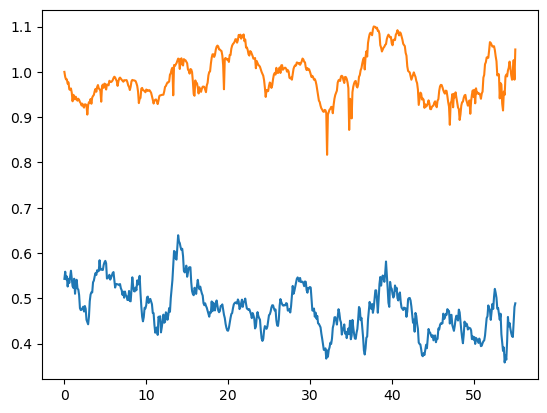

In [8]:
from amuse.community.ph4.interface import ph4
from amuse.ext.LagrangianRadii import LagrangianRadii

gravity = ph4(converter)
gravity.particles.add_particles(bodies)
# A channel is a 'permanent' connection to a code's particle
# set. Multiple calls to a code's particle set need to set up
# a new connection every time; with a channel, we can copy
# information back without opening a new connection.
# This does not automatically update bodies! See below
channel = gravity.particles.new_channel_to(bodies)

times = numpy.arange(0, 1000, 0.1) | units.Myr
RL25 = [] | units.parsec
Rvir = [] | units.parsec
#binary_set = []
#binary_set_mod = []
for time in times:
    gravity.evolve_model(time)
    channel.copy() # Copy from gravity.particles to bodies
    Rvir.append(bodies.virial_radius())
    L = LagrangianRadii(bodies)
    RL25.append(LagrangianRadii(bodies)[5])

    if not time.value_in(units.Myr)%10.0: #if the remainder is not at least 10Myr (ensures steps of 10Myr)
        print("cluster at Time=", time.in_(units.Myr), 
              "Mass=", bodies.mass.sum().in_(units.MSun),
              "Rvir=", Rvir[-1].in_(units.parsec))
    b = bodies.get_binaries()
    if(len(b)>0):
        #binary_set_mod.extend(b[0])
        print("Number of binaries found:", len(b))
        print("first binary:", b[0])
        break

pyplot.plot(times.value_in(units.Myr)[:len(RL25)], RL25.value_in(units.parsec))
pyplot.plot(times.value_in(units.Myr)[:len(Rvir)], Rvir.value_in(units.parsec))
pyplot.show()

In [10]:
#print(len(binary_set_mod))

You have now calculated the dynamical evolution of a small cluster of stars including a realistic mass function.

Assignments and questions:
---------------

### Question 1:
Why do we have to *scale_to_standard()* after assigning the masses and positions to all the particles?

### Question 2:
Run the notebook and describe the evolution of the virial radius.

### Assignment 2:
There is a check for binary detection in the script.
If no binary formed in your run, that is okay.

Run the script again until a binary forms.

### Question 3:
One of the parameters in the binary is the *hardness*.
What is the hardness of the binary from your last run? and explain what is meant with this parameter.

### Assignment 3:
Rewrite the script in such a way that the event loop over time continues indefinitely, but that the code stops as soon as the first binary is detected.

Run the script several times until you have enough first binaries formed to make a histogram of the first-binary formation time-scale.

Now, make a small change to your initial conditions.
A variation could include the dimensionless depth of the potential of the initial King model, the slope of the initial-mass function, its lower limit, or the number of stars in the simulation).

Now redo the calculation in which you generate a histogram of moments of first-binary formation.

Make one figure with both distributions: the original distribution for first-binary formation time and the second series of runs (with the altered initial conditions.
Present both distributions as histograms and as cumulative distributions. 

### Question 4:
Can you understand the difference in first-binary formation-time based on the changes you introduced in the initial conditions?

Did you perform enough runs to make a statistically significant statement about the time of first-binary formation?

### Assignment 4:
Make a cumulative distribution of the masses of the two stars for each first binary and compare it to the initial mass-function.

### Question 5:
Can you understand the difference between the typical masses of the binaries that formed first and the initial mass-function?

In [220]:
#Q1: scale_to_standard scales to N-body units so that the cluster is virialized, and makes the time scale proportional
#to the cluster's dynamical time scale.

#Q2: The virial radius is fluctuating around 1. The kinetic energy pushing outward and the potential energy pushing 
#inward would be expected to cause such fluctuations. It is fluctuating around 1 because we told it to; the radius of
#the cluster was set to 1, then we told the cluster that it was virialized by using scale_to_standard.

In [221]:
#A2: Continue running script until binary forms

In [222]:
#Q3: The hardness of a binary describes how much energy is needed to break it apart; the more energy required, the 
#harder the binary. It is expressed in terms of binding energy above the mean. Hardness: 12.144
print(binary_set[0].timestep)

9623803355.36 s


In [450]:
#A3: First binaries
ogbin = []
for index, i in enumerate(binary_set):
    ogbin.append(binary_set[index].timestep.value_in(units.s))
print(ogbin)
numpy.savetxt('ogIMF.txt', ogbin)

ogbinm = []
for index, i in enumerate(binary_set):
    ogbinm.append(binary_set[index].mass.value_in(units.kg))
print(ogbinm)
numpy.savetxt('ogIMFm.txt', ogbinm)

[9623803355.3556633, 9623803355.3556633, 5131835965.9905939, 5131835965.9905939, 2206420056.7236586, 2206420056.7236586, 9415683694.9490891, 9415683694.9490891, 10954999480.959024, 10954999480.959024, 4538595780.5135155, 4538595780.5135155, 17506786289.35416, 17506786289.35416, 5633249404.8421621, 5633249404.8421621, 9997807213.6606789, 9997807213.6606789, 23219341860.467861, 23219341860.467861, 11117475700.87742, 11117475700.87742, 11050740497.978218, 11050740497.978218, 5172564310.6953392, 5172564310.6953392, 20279502536.380363, 20279502536.380363, 19665956194.340359, 19665956194.340359, 21776266510.022011, 10888133255.011005, 10907430876.415545, 10907430876.415545, 2626573346.5209641, 2626573346.5209641, 2399775760.7227097, 2399775760.7227097, 19808246914.813843, 19808246914.813843, 5819567703.7255049, 5819567703.7255049, 23357432274.797188, 23357432274.797188, 5103007680.7599897, 5103007680.7599897, 10360654042.099697, 10360654042.099697, 11325160636.364473, 11325160636.364473]
[7.

In [452]:
modbin = []
for index, i in enumerate(binary_set_mod):
    modbin.append(binary_set_mod[index].timestep.value_in(units.s))
print(modbin)
numpy.savetxt('modIMF.txt', modbin)

modbinm = []
for index, i in enumerate(binary_set_mod):
    modbinm.append(binary_set_mod[index].mass.value_in(units.kg))
print(modbinm)
numpy.savetxt('modIMFm.txt', modbinm)

[18890607136.67794, 18890607136.67794, 4559460115.4151955, 4559460115.4151955, 22858956128.708012, 22858956128.708012, 11380429823.53389, 11380429823.53389, 19382345932.27903, 19382345932.27903, 24524975691.38147, 24524975691.38147, 10796540375.747137, 10796540375.747137, 9862641970.5707455, 9862641970.5707455, 9892940987.5091438, 9892940987.5091438, 9252835065.1392403, 9252835065.1392403, 10074061127.389095, 10074061127.389095, 3404553925.6320233, 3404553925.6320233, 20312558961.476536, 20312558961.476536, 4566010754.3058949, 4566010754.3058949, 9127942761.4414463, 9127942761.4414463, 10067745438.441233, 10067745438.441233, 18461937644.132423, 18461937644.132423, 20558777623.0863, 20558777623.0863, 1950765489.0601201, 1950765489.0601201, 5156968790.7019081, 5156968790.7019081, 10593303577.299686, 10593303577.299686, 2011015179.8141081, 2011015179.8141081, 8332288453.7862167, 8332288453.7862167, 4664903044.9528189, 4664903044.9528189, 10180604033.902466, 10180604033.902466]
[7.35250764

In [70]:
ogbin1 = pd.read_csv('ogIMF.txt', header=None, names = ['timestep'])
ogbinm1 = pd.read_csv('ogIMFm.txt', header=None, names = ['mass'])
modbin1 = pd.read_csv('modIMF.txt', header=None, names = ['timestep'])
modbinm1 = pd.read_csv('modIMFm.txt', header=None, names = ['mass'])

In [51]:
kyr = 1 | units.kyr
kyr.value_in(units.s)

31556925993.600002

In [72]:
def plot_cdfm(m, alpha_IMF=-2.35):
    mass = 1.0 | units.MSun
    m /= mass.value_in(units.kg)
    m = sorted(m) #Sort the 100 stars in order of mass
    fm = numpy.array([0]) #creating an empty numpy array
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi) #For each star in m, append the star mass + the mass of the previous fm index
    fm /= max(fm)
    return m, fm[:len(m)]

ogbin_cdf = plot_cdfm(ogbinm1['mass'], alpha_IMF=-2.35)
modbin_cdf = plot_cdfm(modbinm1['mass'], alpha_IMF=-2.35)
print(ogbin_cdf[0])
print(modbin_cdf[0])

[0.24180195390658796, 0.24180195390658796, 0.2434493221762019, 0.2434493221762019, 0.24468660262190947, 0.24468660262190947, 0.25713504429263556, 0.25713504429263556, 0.259819690336562, 0.259819690336562, 0.2668318291473946, 0.2668318291473946, 0.2700643445705419, 0.2700643445705419, 0.27480541646209966, 0.27480541646209966, 0.2772075613566899, 0.2772075613566899, 0.27819105173091485, 0.27819105173091485, 0.29877961457533286, 0.29877961457533286, 0.30723852165361853, 0.30723852165361853, 0.30816138820626615, 0.30816138820626615, 0.31307218733249004, 0.31307218733249004, 0.31661943952988153, 0.31661943952988153, 0.32077122869421976, 0.32077122869421976, 0.32994419741548203, 0.32994419741548203, 0.33621564661786685, 0.33621564661786685, 0.34109854555236646, 0.34109854555236646, 0.35608733741967735, 0.35608733741967735, 0.3579222556748257, 0.3579222556748257, 0.37200286946299743, 0.37200286946299743, 0.40026444109087816, 0.40026444109087816, 0.4234027117089962, 0.4234027117089962, 0.43042

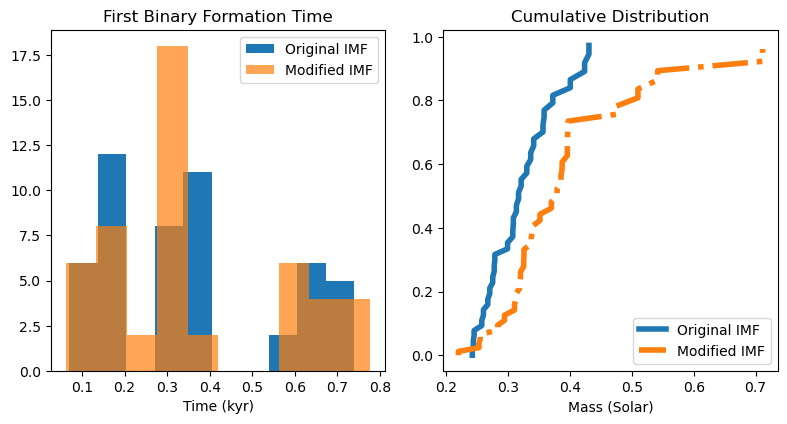

In [57]:
#The alteration was to change W0 from 3.0 to 4.5
#Why are these times in kiloyears? They should be in Myr...

fig,ax = pyplot.subplots(1,2)
fig.set_size_inches(8,4)
fig.tight_layout()

#ax.set_xlim(0.0,1.5)
#ax[0].semilogx()

ax[0].set_title('First Binary Formation Time')
ax[0].set_xlabel('Time (kyr)')

ax[1].set_title('Cumulative Distribution')
ax[1].set_xlabel('Mass (Solar)')

ax[0].hist(ogbin1['timestep']/kyr.value_in(units.s), label="Original IMF")
ax[0].hist(modbin1['timestep']/kyr.value_in(units.s), label="Modified IMF", alpha=0.7)
ax[0].legend(loc=0)

ax[1].plot(ogbin_cdf[0], ogbin_cdf[1], lw=4, ls="-", label="Original IMF")
ax[1].plot(modbin_cdf[0], modbin_cdf[1], lw=4, ls="dashdot", label="Modified IMF")
ax[1].legend(loc=0);

In [54]:
#Q4: It seems that the change made it more likely that binaries be formed around 0.3 kyr. With the original mass function,
#more binaries were made around 0.15 kyr, but fewer binaries around 0.3 kyr. Occurences of binaries around 0.65 kyr remained
#approximately the same.
#I did 25 runs for each set, which I don't really believe is enough for an accurate result. If I had more time, I would run
#this code for much longer.

In [67]:
#A4: Comparing to the IMF
def plot_IMF(m, alpha_IMF=-2.35):
    x = 10**numpy.arange(-1.0, 1.0, 1/len(m)) # 10** 2m evenly spaced values between -1 and 1 in steps of 1/(the length of m)
    y = x**(alpha_IMF+2)
    fy = numpy.array([0])
    for yi in y:
        fy = numpy.append(fy, fy[-1] + yi) #Same as above; append the 2m values in y
    fy /= max(fy) #"Normalize" by dividing by the largest mass
    return x, fy[:len(x)]

theo_IMF = plot_IMF(ogbinm1['mass'], alpha_IMF=-2.35)

In [81]:
ogbin_pairs = ogbinm1[::2]*2
modbin_pairs = modbinm1[::2]*2

def plot_cdfm1(m, alpha_IMF=-2.35):
    m = sorted(m) #Sort the 100 stars in order of mass
    fm = numpy.array([0]) #creating an empty numpy array
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi) #For each star in m, append the star mass + the mass of the previous fm index
    fm /= max(fm)
    return m, fm[:len(m)]

ogb_pairs = plot_cdfm1(ogbin_pairs['mass'], alpha_IMF=-2.35)
modb_pairs = plot_cdfm1(modbin_pairs['mass'], alpha_IMF=-2.35)

IMF_len = plot_IMF(ogbin_pairs['mass'], alpha_IMF=-2.35)

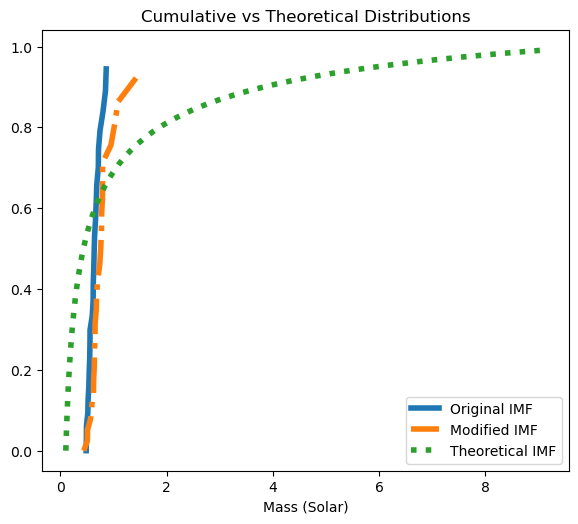

In [82]:
fig,ax = pyplot.subplots(1,1)
fig.set_size_inches(6,5)
fig.tight_layout()

#ax.set_xlim(0.0,1.5)
#ax[0].semilogx()

ax.set_title('Cumulative vs Theoretical Distributions')
ax.set_xlabel('Mass (Solar)')

ax.plot(ogb_pairs[0], ogb_pairs[1], lw=4, ls="-", label="Original IMF")
ax.plot(modb_pairs[0], modb_pairs[1], lw=4, ls="dashdot", label="Modified IMF")
ax.plot(IMF_len[0], IMF_len[1], lw=4, ls=":", label="Theoretical IMF")
ax.legend(loc=0);

In [83]:
#Q5: It definitely seems like the first binaries tend to be of mass less than 1 solar mass. Neither of the binary sets goes
#beyond a mass of 2MSun. It is clear that first binaries do not tend to be large.